In [1]:
## Vae for dna barcode sequence 50 dim and Feedforward Neural Network

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import io
from google.colab import files
from numpy import argmax
from numpy import array
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

original_dim = 3290
intermediate_dim = 256
latent_dim = 50

In [3]:
uploaded = files.upload()

Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_labels.csv to train_labels.csv


In [4]:
train_features_df = pd.read_csv('train_features.csv')
train_labels_df = pd.read_csv('train_labels.csv')
test_features_df = pd.read_csv('test_features.csv')

In [5]:
#get dna barcode sequencing data
def clean_seq(seq_df):
    sequences = seq_df['dna'].str.replace('[^ACGT]','N') #Converting all characters other than A, C, G, T as N
    for i in range(len(sequences)):
        sequences[i] = sequences[i].ljust(1058,'N')
    #print(sequences[0])
    
    sequences_array = np.array(sequences)
    #print(pd.DataFrame(sequences_array))
    seq_list_padded = []
    for i in range(len(sequences_array)):
        list_seq = list(sequences_array[i])
        del list_seq[658:] #truncating seq after 658 characters
        seq_list_padded.append(list_seq)
    print(len(list_seq))
    replace_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4, 'N': 5} 
    integer_encoded = []
    for i in range(len(seq_list_padded)):
        C = (pd.Series(seq_list_padded[i])).map(replace_map) #convert the list to a pandas series temporarily before mapping
        integer_encoded.append(list(C))
    data = np.array([1, 2, 3, 4, 5])
    data = data.reshape(-1, 1) 
    integer_encoded = np.array(integer_encoded).astype(int)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(data)
    one_hot_encoded_seqs = []
    for i in range(len(integer_encoded)):
        integer_encoded_tmp = integer_encoded[i].reshape(len(integer_encoded[i]), 1)
        onehot_encoded = np.array(onehot_encoder.transform(integer_encoded_tmp)).flatten()
        one_hot_encoded_seqs.append(onehot_encoded)
    one_hot_encoded_seqs_array = np.array(one_hot_encoded_seqs)
    #one_hot_encoded_seqs_array = one_hot_encoded_seqs_array.reshape(len(one_hot_encoded_seqs_array), 60, 60)
    #one_hot_encoded_seqs_array = np.expand_dims(one_hot_encoded_seqs_array, axis=3)
    
    return one_hot_encoded_seqs_array

def load_n_encode_labels(df):
    labels = df['labels']
    softmax_layer = len(set(labels))
    le = LabelEncoder()
    le.fit(labels)
    label_seq = le.transform(labels)
    label_seq = label_seq.reshape(len(label_seq), 1)
    
    return label_seq, le, softmax_layer

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

In [6]:
one_hot_encoded_seqs_array_train = clean_seq(train_features_df)
one_hot_encoded_seqs_array_test = clean_seq(test_features_df)
one_hot_encoded_seqs_array = np.row_stack((one_hot_encoded_seqs_array_train, one_hot_encoded_seqs_array_test)) #combining train and test features
label_seq, le, softmax_layer = load_n_encode_labels(train_labels_df) #label_seq is encoded labels
x_train = one_hot_encoded_seqs_array
x_validation = one_hot_encoded_seqs_array_test
train_size = len(x_train)
batch_size = 32


658
658


In [7]:
print(one_hot_encoded_seqs_array_train.shape)
print(one_hot_encoded_seqs_array_test.shape)
print(x_train.shape)
print(x_validation.shape)
x_train = x_train.astype(np.float32)

(12906, 3290)
(8306, 3290)
(21212, 3290)
(8306, 3290)


In [8]:
# make sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

In [10]:
# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
reconstruction_loss = binary_crossentropy(original_inputs,outputs)
reconstruction_loss *= original_dim
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [11]:
epoch_num=50

# Create a callback that saves the model's weights
#https://jonathan-hui.medium.com/tensorflow-save-restore-model-75a1e6d3b9a6
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}", save_weights_only=True,
        save_best_only = True, monitor = "val_loss", verbose =1,)]

In [12]:
# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = vae.fit(x_train, x_train, epochs=epoch_num, batch_size=128, callbacks=callbacks, validation_data=(x_validation, x_validation), verbose=1)

Epoch 1/50
166/166 [==============================] - 4s 9ms/step - loss: 597.5924 - val_loss: 426.1759

Epoch 00001: val_loss improved from inf to 426.17590, saving model to mymodel_1
Epoch 2/50
166/166 [==============================] - 1s 6ms/step - loss: 392.8353 - val_loss: 358.3698

Epoch 00002: val_loss improved from 426.17590 to 358.36975, saving model to mymodel_2
Epoch 3/50
166/166 [==============================] - 1s 6ms/step - loss: 342.3411 - val_loss: 321.2407

Epoch 00003: val_loss improved from 358.36975 to 321.24066, saving model to mymodel_3
Epoch 4/50
166/166 [==============================] - 1s 6ms/step - loss: 310.7480 - val_loss: 293.8522

Epoch 00004: val_loss improved from 321.24066 to 293.85220, saving model to mymodel_4
Epoch 5/50
166/166 [==============================] - 1s 6ms/step - loss: 286.3716 - val_loss: 272.4012

Epoch 00005: val_loss improved from 293.85220 to 272.40125, saving model to mymodel_5
Epoch 6/50
166/166 [==============================]

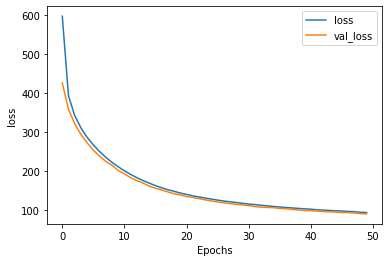

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "loss")

In [14]:
## Classification using Feedforward Neural Network

In [15]:
x_train_encoded = encoder.predict(one_hot_encoded_seqs_array_train)
print(x_train_encoded)
print(x_train_encoded.shape)

[[-2.4044826   1.1257927  -1.7396414  ... -1.9907216   2.227608
  -0.31135565]
 [ 0.02065073 -2.150488    3.646292   ...  4.1206474   3.378119
   3.620016  ]
 [ 1.2369578   0.35304123 -0.19957523 ... -0.18816493  0.77654374
  -4.0487666 ]
 ...
 [ 1.3448528  -3.927857    3.5314488  ...  2.5320086  -3.9282844
   7.5890326 ]
 [ 4.222218   -2.0974538  -5.6984315  ...  2.451741   -2.6419103
   4.0406804 ]
 [ 3.316372    5.897887   -2.1932082  ...  6.3139014   2.4667773
   1.6009723 ]]
(12906, 50)


In [16]:
label_seq = np.ravel(label_seq)
x_sample_train, x_test, y_sample_train, y_test = train_test_split(x_train_encoded, label_seq, test_size=0.2) #train and test split
print(x_sample_train.shape)
print(y_sample_train.shape)
print(x_test.shape)
print(y_test.shape)

(10324, 50)
(10324,)
(2582, 50)
(2582,)


In [18]:
num_epochs = 50
input_dim = x_sample_train.shape[1]
print(input_dim)
# Create a callback that saves the model's weights
#https://jonathan-hui.medium.com/tensorflow-save-restore-model-75a1e6d3b9a6
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}", save_weights_only=True,
        save_best_only = True, monitor = "val_loss", verbose =1,)]

50


In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_dim=input_dim),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(softmax_layer, activation='softmax')
])

In [20]:
optimizer=optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
loss='sparse_categorical_crossentropy'
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               25250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 250)               1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               1

In [21]:
history = model.fit(x_sample_train, y_sample_train, batch_size=64, epochs=num_epochs, callbacks=callbacks, validation_data=(x_test, y_test), verbose=2)

Epoch 1/50
162/162 - 2s - loss: 5.0631 - accuracy: 0.2040 - val_loss: 2.0299 - val_accuracy: 0.6387

Epoch 00001: val_loss improved from inf to 2.02991, saving model to mymodel_1
Epoch 2/50
162/162 - 1s - loss: 2.6251 - accuracy: 0.4619 - val_loss: 1.0694 - val_accuracy: 0.7932

Epoch 00002: val_loss improved from 2.02991 to 1.06938, saving model to mymodel_2
Epoch 3/50
162/162 - 1s - loss: 1.8479 - accuracy: 0.5983 - val_loss: 0.7988 - val_accuracy: 0.8439

Epoch 00003: val_loss improved from 1.06938 to 0.79876, saving model to mymodel_3
Epoch 4/50
162/162 - 1s - loss: 1.5024 - accuracy: 0.6533 - val_loss: 0.7350 - val_accuracy: 0.8602

Epoch 00004: val_loss improved from 0.79876 to 0.73498, saving model to mymodel_4
Epoch 5/50
162/162 - 1s - loss: 1.3032 - accuracy: 0.7023 - val_loss: 0.6221 - val_accuracy: 0.8857

Epoch 00005: val_loss improved from 0.73498 to 0.62209, saving model to mymodel_5
Epoch 6/50
162/162 - 1s - loss: 1.1318 - accuracy: 0.7362 - val_loss: 0.6035 - val_accura

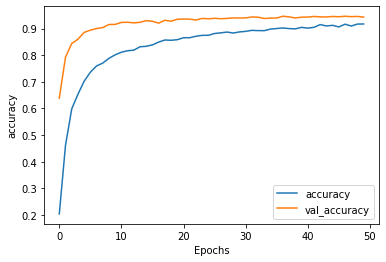

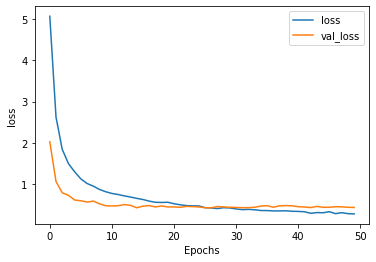

In [22]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [23]:
model.load_weights("mymodel_27")

In [24]:
## Test prediction

In [27]:
x_test_encoded = encoder.predict(one_hot_encoded_seqs_array_test)

encoded_predict_labels = np.argmax(model.predict(x_test_encoded), axis=1)
print(encoded_predict_labels)

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

test_predictions = decode_labels(encoded_predict_labels, le)
print(test_predictions)

[ 659    7  200 ...  339 1059  590]
[ 667    8  205 ...  345 1071  597]


In [29]:
def get_seq_ids(filename):
    df = pd.read_csv(filename)
    ids = df['id']
    
    return np.array(ids)

filename_features_test = 'test_features.csv'

test_ids = get_seq_ids(filename_features_test)
print(test_ids)

frames = [pd.DataFrame(test_ids), pd.DataFrame(test_predictions)]
output_data= np.concatenate(frames, axis=1)
output_df = pd.DataFrame(output_data)
output_df.to_csv('dna_barcode_seq_submission9_vae_embedding_NN.csv', index=False,  header=["id","labels"])

[   1    2    3 ... 8304 8305 8306]


In [30]:
from google.colab import files
files.download("dna_barcode_seq_submission9_vae_embedding_NN.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>